In [67]:
# compute best offset for each
# pull out fasta seqs for each in spreadsheet, remove imperfect
# then do concordance

In [68]:
def GetConcordance(x):
    if x["gral1"] < x["gral2"]:
        g1, g2 = x["gral1"], x["gral2"]
    else: g1, g2 = x["gral2"], x["gral1"]
    if x["imal1"] < x["imal2"]:
        i1, i2 = x["imal1"], x["imal2"]
    else: i1, i2 = x["imal2"], x["imal1"]
    if "." in [g1, g2, i1, i2]: return np.nan
    g1 = int(g1); g2=int(g2); i1=int(i1); i2=int(i2)
    g1 = g1 + x["offset"]
    g2 = g2 + x["offset"]
    if g1 == i1 and g2 == i2: return 1
    elif g1 in [i1, i2] or g2 in [i1, i2]: return 0.5
    else: return 0
    
def GetConcordance2(x):
    diff1 = abs(x["gral1"]-x["gral2"])
    diff2 = abs(x["imal1"]-x["imal2"])
    return int(diff1==diff2)

In [69]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import os

data = pd.read_csv("capillary_vs_imputed_calls.csv")
data["offset"] = 0
data["conc"] = data.apply(GetConcordance, 1)
data = data[~np.isnan(data["conc"])]

Populating the interactive namespace from numpy and matplotlib


In [70]:
MINSAMPLES = 50

# restrict to repeats analyzed in lobstr paper
usestrs = pd.read_csv("marshfield_marker_corrections.tab", sep="\t", names=["chrom","start","end","name2","offset_lob"])
pemb = pd.read_csv("pemberton_sorted.tab", sep="\t", names=["name","name2"])
usestrs = pd.merge(usestrs, pemb, on=["name2"])

# Restrict to loci with at least 50 samples 
names = []
calls = []
for locus in set(usestrs["name"]):
    names.append(locus)
    calls.append(data[(data["name"]==locus) & (data["gral1"]!=".")].shape[0])
callrate = pd.DataFrame({"name": names, "calls": calls})
usestrs = pd.merge(usestrs, callrate, on=["name"])
usestrs = usestrs[usestrs["calls"]>=MINSAMPLES]
data = pd.merge(usestrs, data, on=["name"])

In [71]:
callrate[callrate["calls"]>=0.8*174].shape

(199, 2)

In [72]:
# Restrict to European samples
ONEKGPOP="/home/mgymrek/workspace/ssc-imputation/denovos2/other_data/1000GenomesPopulations.csv"
onekg = pd.read_csv(ONEKGPOP)
eur_samples = list(onekg[onekg["Superpop"]=="EUR"]["sample"])
data = data[data["sample"].apply(lambda x: x in eur_samples)]

In [73]:
# how many loci/samples
print(len(set(data["sample"])))
print(len(set(data["name"])))

41
206


In [74]:
offsets = {}
markers = set(data["name"])
for col in ["gral1","gral2","imal1","imal2"]:
    data[col] = data[col].apply(int)
for marker in markers:
    x = data[data["name"]==marker].copy()
    x["err1"] = -1*(x["gral1"]-x["imal1"])
    x["err2"] = -1*(x["gral1"]-x["imal2"])
    x["err3"] = -1*(x["gral2"]-x["imal1"])
    x["err4"] = -1*(x["gral2"]-x["imal2"])
    possible_offsets = set(list(x["err1"])+list(x["err2"])+ list(x["err3"]) + list(x["err4"]))
    best_offset = 0
    best_conc = 0
    for po in possible_offsets:
        x["offset"] = po
        x["conc"] = x.apply(GetConcordance, 1)
        m = np.mean(x["conc"])
        if m > best_conc:
            best_conc = m
            best_offset = po
    offsets[marker] = best_offset

In [75]:
data["offset"] = data.apply(lambda x: offsets.get(x["name"], 0), 1)
data["conc"] = data.apply(GetConcordance, 1)

print(np.mean(data["conc"]))

0.7685219773378159


In [76]:
markers = list(set(data["name"]))
conc = []
for marker in markers:
    x = data[data["name"]==marker]
    conc.append(np.mean(x["conc"]))
d = pd.DataFrame({"name": markers, "conc": conc})
d = d.sort_values("conc")

(0.9622866790874177, 0.0)


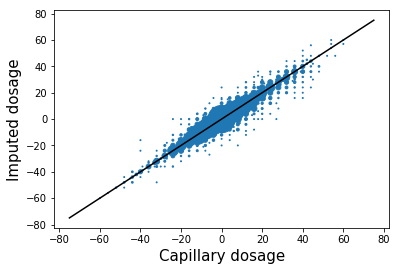

In [77]:
# Bubble plot
data["dosage1"] = data["gral1"]+data["gral2"]+data["offset"]*2
data["dosage2"] = data["imal1"]+data["imal2"]

print(scipy.stats.pearsonr(data["dosage1"], data["dosage2"]))

bubble = data.groupby(["dosage1","dosage2"], as_index=False).agg({"conc": len})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bubble["dosage1"], bubble["dosage2"], s=bubble["conc"])
ax.plot([-75,75],[-75,75], color="black")
ax.set_xlabel("Capillary dosage", size=15)
ax.set_ylabel("Imputed dosage", size=15);

# Per-locus comparison with SSC LOO

In [78]:
DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
sscloo["loo_r2"] = sscloo["loo_r"]**2
sscloo["wgs_eur_r2"] = sscloo["wgs_eur_r"]**2
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","pos"]).drop_duplicates(subset=['pos'])
position_to_id = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/position_to_id/ALL.position_to_id.txt", names=["pos", "str"], delim_whitespace=True)
expected_concordance = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/expected_concordance/ALL.exp_concord.txt", names=["pos", "exp_concord"], delim_whitespace=True)
expected_concordance = pd.merge(expected_concordance, position_to_id, on="pos", how="inner")
sscloo = pd.merge(sscloo, expected_concordance, on="str", how="inner")
sscloo = pd.merge(sscloo[["str","loo_concordance","wgs_eur_concordance","wgs_eur_r2", "loo_r2","exp_concord"]], id_start, on=["str"])

In [79]:
loci = list(set(data["name"]))
conc = []
conc2 = []
r2 = []

for l in loci:
    x = data[data["name"]==l]
    conc.append(np.mean(x.apply(GetConcordance, 1)))
    conc2.append(np.mean(x.apply(GetConcordance2, 1)))
    r2.append(scipy.stats.pearsonr(x["dosage1"], x["dosage2"])[0]**2)
capdata = pd.DataFrame({"str": loci, "cap_conc": conc, "cap_r2": r2, "cap_conc2": conc2})

(0.8303417260396155, 1.050336256812244e-53)
206


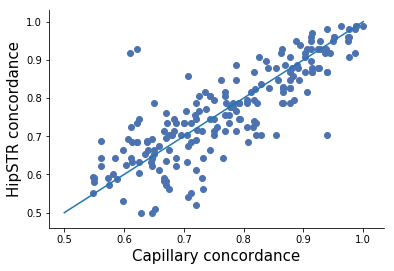

In [80]:
comp = pd.merge(capdata, sscloo, on=["str"])

true_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
exp_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(comp["cap_conc"], comp["wgs_eur_concordance"], color=true_color)
#ax.scatter(comp["cap_conc"], comp["exp_concord"], color=exp_color)
ax.plot([0.5, 1], [0.5,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Capillary concordance", size=15)
ax.set_ylabel("HipSTR concordance", size=15)
fig.savefig("../haplotype_paper/FiguresRevision/pdfs/Figure2_Capillary.pdf")
print(scipy.stats.pearsonr(comp["cap_conc"], comp["wgs_eur_concordance"]))
print(comp.shape[0])